In [84]:
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from functions import kaggle_download, barplot_share, info_splitter, calc_split_summary, objective

from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb 
import optuna
from sklearn.model_selection import train_test_split, KFold

seed=123

## Modeling - preparation
Features chosen to modeling:
1. Age
2. KM's driven
3. make_new_1 
4. make_new_2 
5. is_petrol
6. Assembly
7. registration_city
8. Transmission
9. Car features - these variable is already encoded to 0/1 variables.

### Features encoding
Encoding of categorical features for variables with only two possible value will be made as one hot encoding while the others (make and registration city) will be made as label encoder sorted by average price which helps decision tree based algorithm to produce smaller trees with the same accuracy.

In [81]:
data= pd.read_csv('olx_cars_adjusted.csv')

In [82]:
data_cols_old = data.columns
data_cols_new  = [i.replace(' ','_') for i in data_cols_old]

In [83]:
to_change = dict(map(lambda i,j : (i,j) , data_cols_old,data_cols_new))
data = data.rename(to_change, axis=1)

In [26]:
cols_to_one_hot = ['is_petrol', 'Assembly', 'Transmission']
cols_to_one_hot_enc = ['is_petrol_True', 'Assembly_Local','Transmission_Manual']
cols_to_avg = ['make_new_1', 'make_new_2', 'registration_city']
cols_avg_enc = [i + "_encoded" for i in cols_to_avg ]
numerical_features_x =["KM's driven", 'Age']
data = pd.get_dummies(data=data, columns=cols_to_one_hot, drop_first=True)

In [ ]:
data.drop('Price', axis=1)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(,data['Price'], test_size=0.3, random_state=seed)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
j= 0
for i in cols_to_avg:
    encoding = train_X[['Price',i]].groupby(i).mean().sort_values(by='Price')
    encoding[f'{i}_encoded'] = np.arange(0,encoding.shape[0])
    del encoding
    train_X = train_X

In [86]:

target_mean_encoder = TargetEncoder(smoothing=0, min_samples_leaf=1)
x_train_target_encoded = pd.DataFrame(target_mean_encoder.fit_transform(train_X[cols_to_avg], train_y).values,columns=cols_avg_enc)
x_test_target_encoded = pd.DataFrame(target_mean_encoder.transform(test_X[cols_to_avg]).values,columns=cols_avg_enc)
data_encoded = pd.DataFrame(target_mean_encoder.transform(test_X[cols_to_avg]).values,columns=cols_avg_enc)

In [87]:
x_train_target_encoded.head()

,make_new_1_encoded,make_new_2_encoded,registration_city_encoded
0,2.664544e+06,2.664544e+06,1.928731e+06
1,1.487175e+06,1.457657e+06,1.928731e+06
2,3.189804e+06,3.187199e+06,1.938703e+06
3,1.487175e+06,1.457657e+06,2.091037e+06
4,2.664544e+06,2.664544e+06,2.091037e+06


In [88]:
lb = LabelEncoder()
train_X['make_new_1_encoded'] = lb.fit_transform(x_train_target_encoded['make_new_1_encoded'])

In [90]:
train_X.groupby('make_new_1_encoded').mean()['Price']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8028\185340989.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_X.groupby('make_new_1_encoded').mean()['Price']


KeyError: 'Price'

In [28]:
train_X = train_X.join(x_train_target_encoded)
test_X = test_X.join(x_test_target_encoded)

In [29]:
all_features = ['USB and Auxillary Cable',
 'AM/FM Radio',
 'Heated Seats',
 'ABS',
 'Power Steering',
 'Rear Camera',
 'Climate Control',
 'Power Windows',
 'DVD Player',
 'Cool Box',
 'Keyless Entry',
 'Air Conditioning',
 'Rear Seat Entertainment',
 'Immobilizer Key',
 'Power Locks',
 'Sun Roof',
 'Cruise Control',
 'Air Bags',
 'Front Speakers',
 'CD Player',
 'Power Mirrors',
 'Rear speakers',
 'Steering Switches',
 'Front Camera',
 'Rear AC Vents',
 'Cassette Player',
 'Navigation System',
 'Alloy Rims']

In [30]:
final_models_feature = []
final_models_feature.extend(numerical_features_x)
final_models_feature.extend(cols_avg_enc)
final_models_feature.extend(all_features)
final_models_feature.extend(cols_to_one_hot_enc)

In [31]:
categorical_features = []
categorical_features.extend(cols_avg_enc)
categorical_features.extend(all_features)
categorical_features.extend(cols_to_one_hot_enc)

In [42]:
train_lgb = lgb.Dataset(data=train_X[final_models_feature], label=train_y)

In [33]:
study = optuna.create_study(direction='minimize')

[I 2024-01-07 18:34:57,414] A new study created in memory with name: no-name-303a1ed7-59f8-4b19-806e-b16ab0ef589f


In [ ]:
study.best_params

In [ ]:
study.optimize(lambda trial: objective(trial,train_x=train_X,obj='rmse', train_y=train_y,seed=seed,numerical_features=numerical_features_x,
                                       cat_features=categorical_features), n_trials=20)

In [36]:
study.best_params

{'boosting': 'gbdt',
 'num_iterations': 64,
 'learning_rate': 0.22816688655399328,
 'max_depth': 10,
 'min_data_in_leaf': 50,
 'bagging_fraction': 0.46874741557677346,
 'lambda_l1': 4.902574676858617,
 'lambda_l2': 1.1860734255180363,
 'linear_lambda': 7.937337911508984,
 'min_gain_to_split': 8.122584161347834}

In [44]:
final_model = lgb.cv(params=study.best_params,
                    train_set=train_lgb, 
                   nfold=3,
                   seed=seed,
                   metrics='rmse',
                   return_cvbooster=True)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'num_iterations' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 4069, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since yo

In [38]:
from sklearn.metrics import r2_score

In [59]:
m0 = final_model['cvbooster'].boosters[0]
final_features = m0.feature_name()

In [66]:
all_featrues_new = [i.replace(' ','_') for i in all_features]

In [74]:
dd = dict(keys = all_features, values = all_featrues_new)

In [77]:
res['USB and Auxillary Cable']

'USB_and_Auxillary_Cable'

,Unnamed: 0,Ad ID,Car Name,Make,Model,Year,KM's driven,Price,Fuel,Registration city,...,Rear_speakers,Steering_Switches,Front_Camera,Rear_AC_Vents,Cassette_Player,Navigation_System,Alloy_Rims,is_petrol_True,Assembly_Local,Transmission_Manual
0,0,1080434207,Changan Alsvin 1.5 Lumiere,Changan,Alsvin,2022,8500,4200000,Petrol,Lahore,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0
1,1,1080155972,Changan alsvin lumiere 2022 Model,Changan,Alsvin,2022,2200,4100000,Petrol,Lahore,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0
2,2,1080646142,chang an Alsvin Lumiere,Changan,Alsvin,2021,17000,3950000,Petrol,Punjab,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1,1,0
3,3,1080491687,Changan alsvin Lumiere 2022,Changan,Alsvin,2022,15000,3785000,Petrol,Punjab,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,1,1
4,4,1080971973,Alsvin Lumeire Model 2022 - Urgent Sale,Changan,Alsvin,2022,27000,4075000,Petrol,Islamabad,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8716,8716,1078453186,toyota yaris October 2020 Islamabad Registered,Toyota,Yaris,2020,54000,4500000,Petrol,Islamabad,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1,1,0
8717,8717,1071092728,Toyota Yaris,Toyota,Yaris,2021,18500,4050000,Petrol,Punjab,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,1
8718,8718,1075869467,Yaris 1.3 ATIV CVT 2022,Toyota,Yaris,2022,12000,4700000,Petrol,Punjab,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0
8719,8719,1079723349,Toyota Yaris ATIV CVT for sale Lady Doctor pro...,Toyota,Yaris,2020,55000,3900000,Petrol,Karachi,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1,1,0


In [67]:
all_featrues_new

['USB_and_Auxillary_Cable',
 'AM/FM_Radio',
 'Heated_Seats',
 'ABS',
 'Power_Steering',
 'Rear_Camera',
 'Climate_Control',
 'Power_Windows',
 'DVD_Player',
 'Cool_Box',
 'Keyless_Entry',
 'Air_Conditioning',
 'Rear_Seat_Entertainment',
 'Immobilizer_Key',
 'Power_Locks',
 'Sun_Roof',
 'Cruise_Control',
 'Air_Bags',
 'Front_Speakers',
 'CD_Player',
 'Power_Mirrors',
 'Rear_speakers',
 'Steering_Switches',
 'Front_Camera',
 'Rear_AC_Vents',
 'Cassette_Player',
 'Navigation_System',
 'Alloy_Rims']

In [65]:
all_features[0].replace(' ', '_')

'USB_and_Auxillary_Cable'

In [63]:
df.rename all_features

['USB and Auxillary Cable',
 'AM/FM Radio',
 'Heated Seats',
 'ABS',
 'Power Steering',
 'Rear Camera',
 'Climate Control',
 'Power Windows',
 'DVD Player',
 'Cool Box',
 'Keyless Entry',
 'Air Conditioning',
 'Rear Seat Entertainment',
 'Immobilizer Key',
 'Power Locks',
 'Sun Roof',
 'Cruise Control',
 'Air Bags',
 'Front Speakers',
 'CD Player',
 'Power Mirrors',
 'Rear speakers',
 'Steering Switches',
 'Front Camera',
 'Rear AC Vents',
 'Cassette Player',
 'Navigation System',
 'Alloy Rims']

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

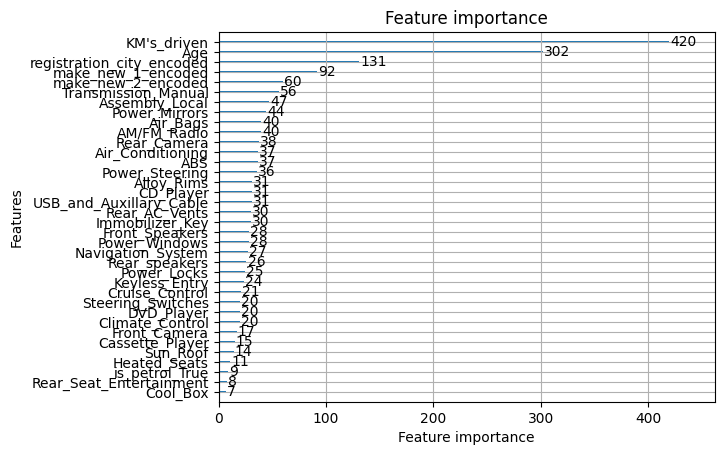

In [61]:
lgb.plot_importance(m0)

In [62]:
pred_train = final_model['cvbooster'].predict(train_X[final_features])

KeyError: '["KM\'s_driven", \'USB_and_Auxillary_Cable\', \'AM/FM_Radio\', \'Heated_Seats\', \'Power_Steering\', \'Rear_Camera\', \'Climate_Control\', \'Power_Windows\', \'DVD_Player\', \'Cool_Box\', \'Keyless_Entry\', \'Air_Conditioning\', \'Rear_Seat_Entertainment\', \'Immobilizer_Key\', \'Power_Locks\', \'Sun_Roof\', \'Cruise_Control\', \'Air_Bags\', \'Front_Speakers\', \'CD_Player\', \'Power_Mirrors\', \'Rear_speakers\', \'Steering_Switches\', \'Front_Camera\', \'Rear_AC_Vents\', \'Cassette_Player\', \'Navigation_System\', \'Alloy_Rims\'] not in index'